In [1]:
from pythainlp.corpus import stopwords
from pythainlp.tokenize import word_tokenize
from wordcloud import (WordCloud, get_single_color_func)
from matplotlib import pyplot as plt
import os ## สำหรับใช้กับ mac
import json
os.environ['KMP_DUPLICATE_LIB_OK']='True' ## สำหรับใช้กับ mac
import string
import re
import numpy as np
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

### อ่านคำแง่บวกแง่ลบมาจากไฟล์ ที่มา https://github.com/PyThaiNLP/lexicon-thai

In [2]:
pos = []
with open("pos.txt", "r") as ins:
    for line in ins:
        pos.append(line)
pos = [''.join(c for c in text if c not in '\n') for text in pos]
neg = []
with open("neg.txt", "r") as ins:
    for line in ins:
        neg.append(line)
neg = [''.join(c for c in text if c not in '\n') for text in neg]

In [3]:
class SimpleGroupedColorFunc(object):

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [4]:
# clean data
def cleandata(search_result):
    list_sentent = []
    for ret in search_result:
        ret = re.sub(r'https?:\/\/(.+?)(\/.*)', "", str(ret)) # link pattern
        list_word = word_tokenize(ret)
        list_word = [''.join(c for c in word if c not in string.punctuation) for word in list_word] #ลบสัญลักษณ์
        list_word = [word for word in list_word if word] #ทำให้เหลือแต่ตัวที่ไม่สัญลักษณ์
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U0001F1F2-\U0001F1F4"  # Macau flag
            u"\U0001F1E6-\U0001F1FF"  # flags
            u"\U0001F600-\U0001F64F"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U0001F1F2"
            u"\U0001F1F4"
            u"\U0001F620"
            u"\u200d"
            u"\u2640-\u2642"
            "]+", flags=re.UNICODE)
        list_word = [emoji_pattern.sub(r'', word) for word in list_word] #ลบ emoji
        list_word = [word.replace(" ", "") for word in list_word]
        list_word = [word for word in list_word if word != ''] #ลบช่องว่าง
        list_word = [''.join(c for c in text if c not in '\n') for text in list_word] #ลบขึ้นบรรทัดใหม่
        list_word = [word for word in list_word if not any(x.isdigit() for x in word)] #ลบตัวเลข
        list_sentent.append(''.join(list_word))
    return list_sentent

In [5]:
def getmoreresult(str):
    results = []
    maxid = 0
    while(True):
        result = t.search.tweets(q=str+" -filter:retweets",count=100,retry=True,max_id=maxid-1,tweet_mode='extended')
        if len(result['statuses']) > 0:
            results.append(result)
            maxid = result['statuses'][len(result['statuses'])-1]['id']
        else: break
    return results

In [6]:
def getonlystatus(twresult):
    results = []
    for re in twresult:
        for status in re['statuses']:
            results.append(status['full_text'])
    return results

In [7]:
#delete stop word
def delStopWord(search_result):
    list_sentent = []
    for ret in search_result:
        list_word = word_tokenize(ret)
        list_word = [word for word in list_word if word not in stopwords.words('thai')]
        list_sentent.append(''.join(list_word))
    return list_sentent

In [8]:
def delStopWord(search_result):
    list_sentent = []
    for ret in search_result:
        list_word = word_tokenize(ret)
        list_word = [word for word in list_word if word not in stopwords.words('thai')]
        list_sentent.append(''.join(list_word))
    return list_sentent

In [9]:
def countSentiment(sentence,wordList,polarity):
    count = 0
    list = []
    for word in wordList:
        if word in sentence:
            count += sentence.count(word)
            list.append(polarity + word)
    return [count,list]


def sentimentType(sentence):
    
    posCount = countSentiment(sentence,pos,'+')
    negCount = countSentiment(sentence,neg,'-')
    r = [''.join(sentence),
         posCount[1] + negCount[1]]
    if(posCount[0] > negCount[0]):
        r[1].append('positive')
    elif posCount[0] < negCount[0]:
        r[1].append('negative')
    else:
        r[1].append('-')
    
    return r

In [10]:
from twitter import *
t = Twitter(auth=OAuth(
                       '73811473-drETE82TvG8sEZzmus8lofg2NdBpnt3PED8dxxPj7',
                       '7Bl9w490EvOHrloFyUrENqdMhrluAdBVsg69zaLSRMuOl','Mg7CVxmU3u7axLXab6wt115Ph',
                       '3E3eDkt53fhq7TRS2kzesQnJSaCzyXaB0OkI6D2cUNxj1Uyemp'),retry=True)

In [11]:
results_count = []
results_label = []
results_count_pos_personal = []
results_label_pos_personal = []
results_count_neg_personal = []
results_label_neg_personal = []
results_count_neu_personal = []
results_label_neu_personal = []
results_count_pos_party = []
results_label_pos_party = []
results_count_neg_party = []
results_label_neg_party = []
results_count_neu_party = []
results_label_neu_party = []

In [12]:
def countNegOrPos(list_sentence):
    pos = 0
    neg = 0
    neu = 0
    for sen in list_sentence:
        output = sentimentType(sen)
        if output[1][len(output[1])-1] == 'positive':
            pos = pos+1
        elif output[1][len(output[1])-1] == 'negative':
            neg = neg+1
        else:
            neu = neu+1
    result = []
    result.append(pos)
    result.append(neg)
    result.append(neu)
    return result

In [13]:
result_countPosNeg_labels = ['Positive','Negative','Neutral']

# คำค้นหาเกี่ยวกับเลือกตั้ง

In [14]:
เลือกตั้ง = getmoreresult('เลือกตั้ง')

In [15]:
เลือกตั้ง_onlystatus = getonlystatus(เลือกตั้ง)
เลือกตั้ง_afterclean = cleandata(เลือกตั้ง_onlystatus)
เลือกตั้ง_afterDelStopWord = delStopWord(เลือกตั้ง_afterclean)

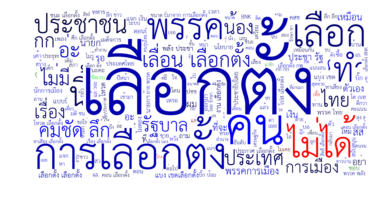

In [16]:
เลือกตั้ง_wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(เลือกตั้ง_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
เลือกตั้ง_wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(เลือกตั้ง_wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
เลือกตั้ง_wordcloud.to_file('เลือกตั้ง.jpg')

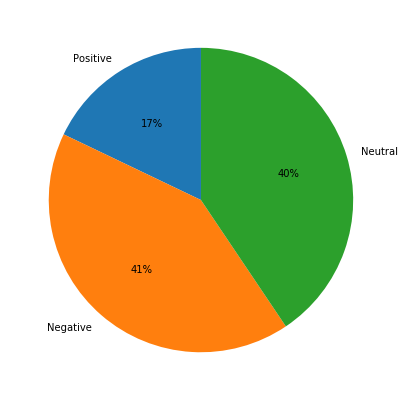

In [17]:
result = countNegOrPos(เลือกตั้ง_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [18]:
เลือกตั้ง_count = len(เลือกตั้ง_onlystatus)

# พรรคประชาธิปัตย์ : อภิสิทธิ์

In [19]:
อภิสิทธิ์ = getmoreresult('อภิสิทธิ์')

In [20]:
อภิสิทธิ์_onlystatus = getonlystatus(อภิสิทธิ์)
อภิสิทธิ์_afterclean = cleandata(อภิสิทธิ์_onlystatus)
อภิสิทธิ์_afterDelStopWord = delStopWord(อภิสิทธิ์_afterclean)

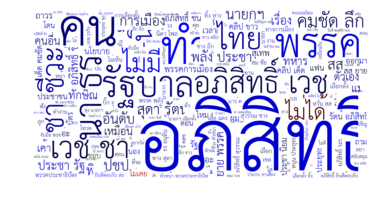

In [21]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(อภิสิทธิ์_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('อภิสิทธิ์.jpg')

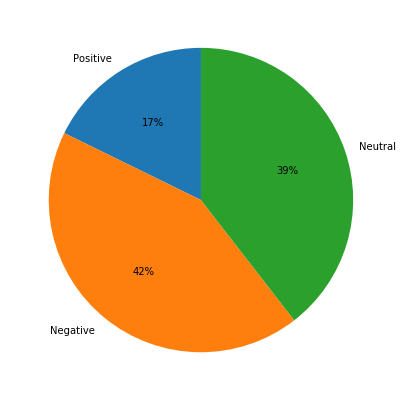

In [22]:
อภิสิทธิ์_result = countNegOrPos(อภิสิทธิ์_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(อภิสิทธิ์_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [23]:
label = "Abhisit Vejjajiva"
results_count_pos_personal.append(อภิสิทธิ์_result[0])
results_label_pos_personal.append(label)
results_count_neg_personal.append(อภิสิทธิ์_result[1])
results_label_neg_personal.append(label)
results_count_neu_personal.append(อภิสิทธิ์_result[2])
results_label_neu_personal.append(label)

In [24]:
ประชาธิปัตย์ = getmoreresult('ประชาธิปัตย์')
ประชาธิปัตย์_onlystatus = getonlystatus(ประชาธิปัตย์)
ประชาธิปัตย์_afterclean = cleandata(ประชาธิปัตย์_onlystatus)
ประชาธิปัตย์_afterDelStopWord = delStopWord(ประชาธิปัตย์_afterclean)

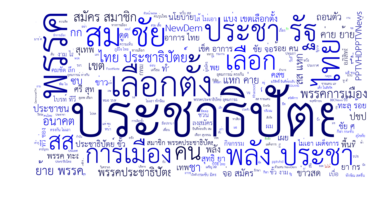

In [25]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(ประชาธิปัตย์_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('ประชาธิปัตย์.jpg')

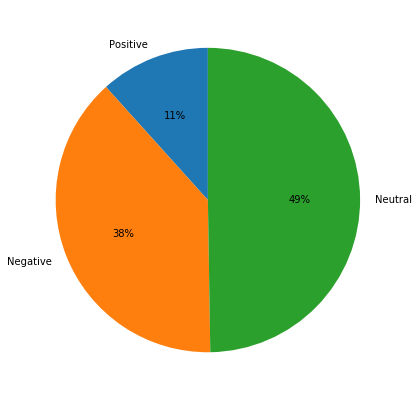

In [26]:
ประชาธิปัตย์_result = countNegOrPos(ประชาธิปัตย์_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(ประชาธิปัตย์_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [27]:
ประชาธิปัตย์_count = len(ประชาธิปัตย์_onlystatus)+len(อภิสิทธิ์_onlystatus)
results_count.append(ประชาธิปัตย์_count)
results_label.append(u'Prachatipad')

In [28]:
label = "Prachatipad"
results_count_pos_party.append(ประชาธิปัตย์_result[0])
results_label_pos_party.append(label)
results_count_neg_party.append(ประชาธิปัตย์_result[1])
results_label_neg_party.append(label)
results_count_neu_party.append(ประชาธิปัตย์_result[2])
results_label_neu_party.append(label)

# พรรคเพื่อไทย : วิโรจน์

In [29]:
วิโรจน์ = getmoreresult('วิโรจน์')
วิโรจน์_onlystatus = getonlystatus(วิโรจน์)
วิโรจน์_afterclean = cleandata(วิโรจน์_onlystatus)
วิโรจน์_afterDelStopWord = delStopWord(วิโรจน์_afterclean)

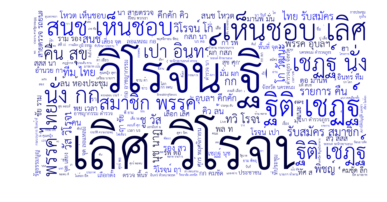

In [30]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(วิโรจน์_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('วิโรจน์.jpg')

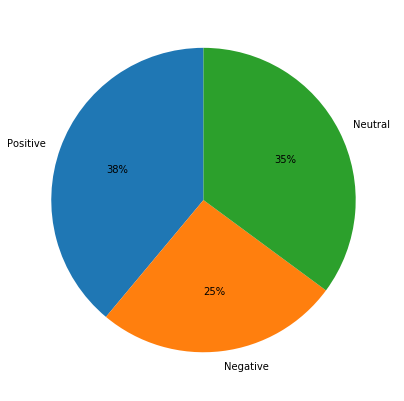

In [31]:
วิโรจน์_result = countNegOrPos(วิโรจน์_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(วิโรจน์_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [32]:
label = "Viroge"
results_count_pos_personal.append(วิโรจน์_result[0])
results_label_pos_personal.append(label)
results_count_neg_personal.append(วิโรจน์_result[1])
results_label_neg_personal.append(label)
results_count_neu_personal.append(วิโรจน์_result[2])
results_label_neu_personal.append(label)

In [33]:
เพื่อไทย = getmoreresult('เพื่อไทย')
เพื่อไทย_onlystatus = getonlystatus(เพื่อไทย)
เพื่อไทย_afterclean = cleandata(เพื่อไทย_onlystatus)
เพื่อไทย_afterDelStopWord = delStopWord(เพื่อไทย_afterclean)

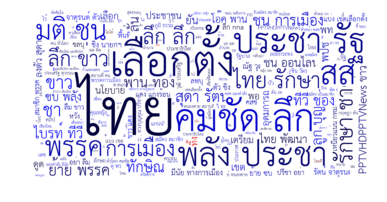

In [34]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(เพื่อไทย_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('เพื่อไทย.jpg')

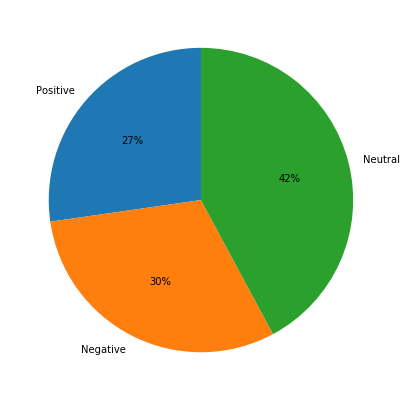

In [35]:
เพื่อไทย_result = countNegOrPos(เพื่อไทย_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(เพื่อไทย_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [36]:
เพื่อไทย_count = len(เพื่อไทย_onlystatus)+len(วิโรจน์_onlystatus)
results_count.append(เพื่อไทย_count)
results_label.append('Puethai')

In [37]:
label = "Puethai"
results_count_pos_party.append(เพื่อไทย_result[0])
results_label_pos_party.append(label)
results_count_neg_party.append(เพื่อไทย_result[1])
results_label_neg_party.append(label)
results_count_neu_party.append(เพื่อไทย_result[2])
results_label_neu_party.append(label)

# พรรคชาติไทยพัฒนา : กัญจนา

In [38]:
กัญจนา = getmoreresult('กัญจนา')
กัญจนา_onlystatus = getonlystatus(กัญจนา)
กัญจนา_afterclean = cleandata(กัญจนา_onlystatus)
กัญจนา_afterDelStopWord = delStopWord(กัญจนา_afterclean)

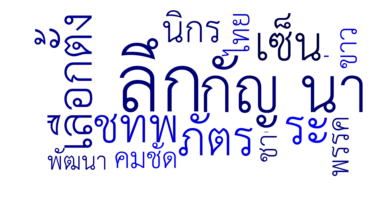

In [39]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(กัญจนา_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('กัญจนา.jpg')

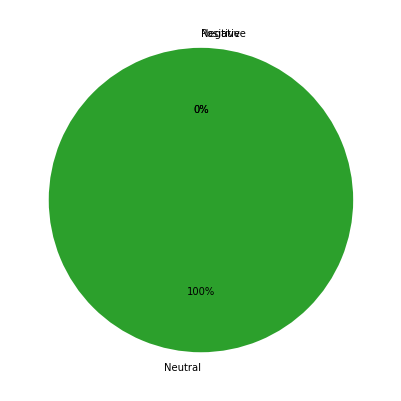

In [40]:
กัญจนา_result = countNegOrPos(กัญจนา_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(กัญจนา_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [41]:
label = "Karnjana"
results_count_pos_personal.append(กัญจนา_result[0])
results_label_pos_personal.append(label)
results_count_neg_personal.append(กัญจนา_result[1])
results_label_neg_personal.append(label)
results_count_neu_personal.append(กัญจนา_result[2])
results_label_neu_personal.append(label)

In [42]:
ชาติไทยพัฒนา = getmoreresult('ชาติไทยพัฒนา')
ชาติไทยพัฒนา_onlystatus = getonlystatus(ชาติไทยพัฒนา)
ชาติไทยพัฒนา_afterclean = cleandata(ชาติไทยพัฒนา_onlystatus)
ชาติไทยพัฒนา_afterDelStopWord = delStopWord(ชาติไทยพัฒนา_afterclean)

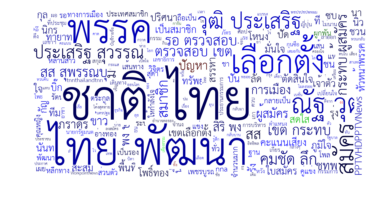

In [43]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(ชาติไทยพัฒนา_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('ชาติไทยพัฒนา.jpg')

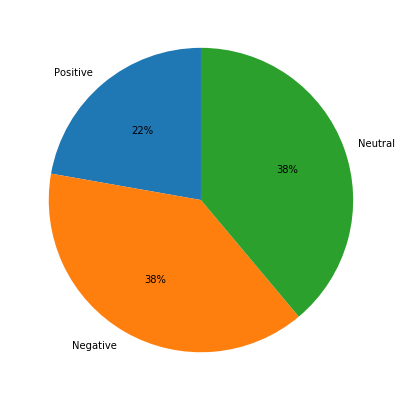

In [44]:
ชาติไทยพัฒนา_result = countNegOrPos(ชาติไทยพัฒนา_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(ชาติไทยพัฒนา_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [45]:
ชาติไทยพัฒนา_count = len(ชาติไทยพัฒนา_onlystatus)+len(กัญจนา_onlystatus)
results_count.append(ชาติไทยพัฒนา_count)
results_label.append('Charthaipatana')

In [46]:
label = "Charthaipatana"
results_count_pos_party.append(ชาติไทยพัฒนา_result[0])
results_label_pos_party.append(label)
results_count_neg_party.append(ชาติไทยพัฒนา_result[1])
results_label_neg_party.append(label)
results_count_neu_party.append(ชาติไทยพัฒนา_result[2])
results_label_neu_party.append(label)

# พรรคภูมิใจไทย : อนุทิน

In [47]:
ภูมิใจไทย = getmoreresult('ภูมิใจไทย')
ภูมิใจไทย_onlystatus = getonlystatus(ภูมิใจไทย)
ภูมิใจไทย_afterclean = cleandata(ภูมิใจไทย_onlystatus)
ภูมิใจไทย_afterDelStopWord = delStopWord(ภูมิใจไทย_afterclean)

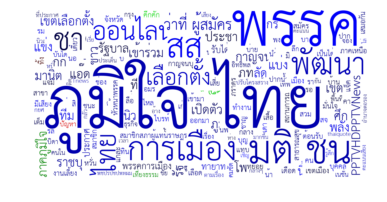

In [48]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(ภูมิใจไทย_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('ภูมิใจไทย.jpg')

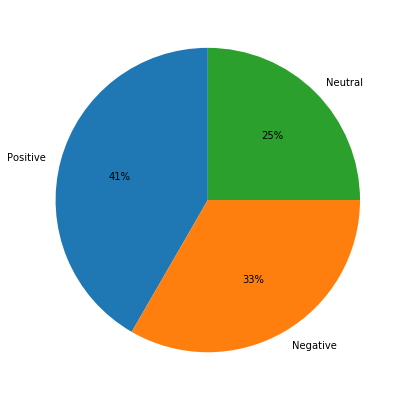

In [49]:
ภูมิใจไทย_result = countNegOrPos(ภูมิใจไทย_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(ภูมิใจไทย_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [50]:
อนุทิน = getmoreresult('อนุทิน')
อนุทิน_onlystatus = getonlystatus(อนุทิน)
อนุทิน_afterclean = cleandata(อนุทิน_onlystatus)
อนุทิน_afterDelStopWord = delStopWord(อนุทิน_afterclean)

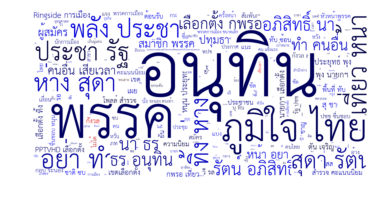

In [51]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(อนุทิน_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('อนุทิน.jpg')

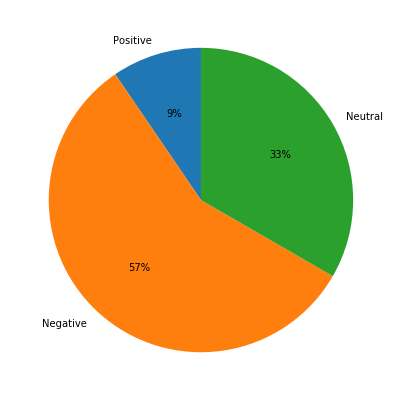

In [52]:
อนุทิน_result = countNegOrPos(อนุทิน_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(อนุทิน_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [53]:
label = "Anutin"
results_count_pos_personal.append(อนุทิน_result[0])
results_label_pos_personal.append(label)
results_count_neg_personal.append(อนุทิน_result[1])
results_label_neg_personal.append(label)
results_count_neu_personal.append(อนุทิน_result[2])
results_label_neu_personal.append(label)

In [54]:
ภูมิใจไทย_count = len(ภูมิใจไทย_onlystatus)+len(อนุทิน_onlystatus)
results_count.append(ภูมิใจไทย_count)
results_label.append('Phumjaithai')

In [55]:
label = "Phumjaithai"
results_count_pos_party.append(ภูมิใจไทย_result[0])
results_label_pos_party.append(label)
results_count_neg_party.append(ภูมิใจไทย_result[1])
results_label_neg_party.append(label)
results_count_neu_party.append(ภูมิใจไทย_result[2])
results_label_neu_party.append(label)

# พรรคเสรีรวมไทย : เสรีพิศุทธ์

In [56]:
เสรีรวมไทย = getmoreresult('เสรีรวมไทย')
เสรีรวมไทย_onlystatus = getonlystatus(เสรีรวมไทย)
เสรีรวมไทย_afterclean = cleandata(เสรีรวมไทย_onlystatus)
เสรีรวมไทย_afterDelStopWord = delStopWord(เสรีรวมไทย_afterclean)

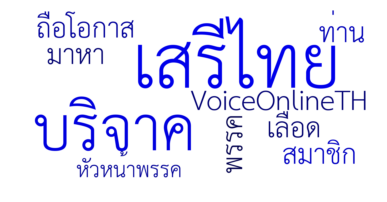

In [57]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(เสรีรวมไทย_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('เสรีรวมไทย.jpg')

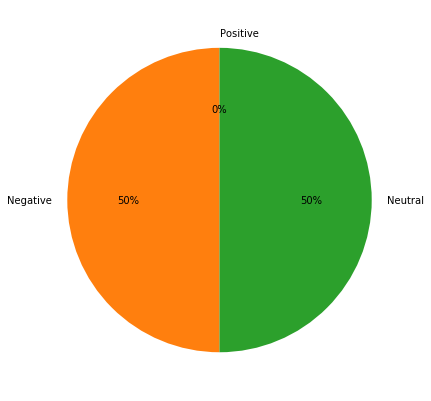

In [58]:
เสรีรวมไทย_result = countNegOrPos(เสรีรวมไทย_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(เสรีรวมไทย_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [59]:
เสรีพิศุทธ์ = getmoreresult('เสรีพิศุทธ์')
เสรีพิศุทธ์_onlystatus = getonlystatus(เสรีพิศุทธ์)
เสรีพิศุทธ์_afterclean = cleandata(เสรีพิศุทธ์_onlystatus)
เสรีพิศุทธ์_afterDelStopWord = delStopWord(เสรีพิศุทธ์_afterclean)

In [60]:
len(เสรีพิศุทธ์_onlystatus)

0

In [61]:
เสรีพิศุทธ์_result = countNegOrPos(เสรีพิศุทธ์_afterDelStopWord)

In [62]:
label = "Seripisut"
results_count_pos_personal.append(เสรีพิศุทธ์_result [0])
results_label_pos_personal.append(label)
results_count_neg_personal.append(เสรีพิศุทธ์_result [1])
results_label_neg_personal.append(label)
results_count_neu_personal.append(เสรีพิศุทธ์_result [2])
results_label_neu_personal.append(label)

In [63]:
เสรีรวมไทย_count = len(เสรีรวมไทย_onlystatus)+len(เสรีพิศุทธ์_onlystatus)
results_count.append(เสรีรวมไทย_count)
results_label.append('Seriruamthai')

In [64]:
label = "Seriruamthai"
results_count_pos_party.append(เสรีรวมไทย_result[0])
results_label_pos_party.append(label)
results_count_neg_party.append(เสรีรวมไทย_result[1])
results_label_neg_party.append(label)
results_count_neu_party.append(เสรีรวมไทย_result[2])
results_label_neu_party.append(label)

# พรรคพลังประชารัฐ : ชวน ชูจันทร์

In [65]:
พลังประชารัฐ = getmoreresult('พลังประชารัฐ')
พลังประชารัฐ_onlystatus = getonlystatus(พลังประชารัฐ)
พลังประชารัฐ_afterclean = cleandata(พลังประชารัฐ_onlystatus)
พลังประชารัฐ_afterDelStopWord = delStopWord(พลังประชารัฐ_afterclean)

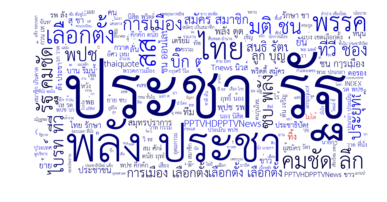

In [66]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(พลังประชารัฐ_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('พลังประชารัฐ.jpg')

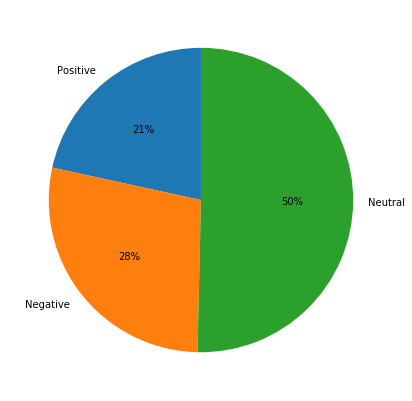

In [67]:
พลังประชารัฐ_result = countNegOrPos(พลังประชารัฐ_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(พลังประชารัฐ_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [68]:
ชวน_ชูจันทร์ = getmoreresult('ชวน ชูจันทร์')
ชวน_ชูจันทร์_onlystatus = getonlystatus(ชวน_ชูจันทร์)
ชวน_ชูจันทร์_afterclean = cleandata(ชวน_ชูจันทร์_onlystatus)
ชวน_ชูจันทร์_afterDelStopWord = delStopWord(ชวน_ชูจันทร์_afterclean)

In [69]:
len(ชวน_ชูจันทร์_onlystatus)

0

In [70]:
label = "Chuan Chujan"
results_count_pos_personal.append(0)
results_label_pos_personal.append(label)
results_count_neg_personal.append(0)
results_label_neg_personal.append(label)
results_count_neu_personal.append(0)
results_label_neu_personal.append(label)

In [71]:
พลังประชารัฐ_count = len(พลังประชารัฐ_onlystatus)+len(ชวน_ชูจันทร์_onlystatus)
results_count.append(พลังประชารัฐ_count)
results_label.append('Palangpacharat')

In [72]:
label = "Palangpacharat"
results_count_pos_party.append(พลังประชารัฐ_result[0])
results_label_pos_party.append(label)
results_count_neg_party.append(พลังประชารัฐ_result[1])
results_label_neg_party.append(label)
results_count_neu_party.append(พลังประชารัฐ_result[2])
results_label_neu_party.append(label)

# พรรคอนาคตใหม่ : ธนาธร

In [73]:
อนาคตใหม่ = getmoreresult('อนาคตใหม่')
อนาคตใหม่_onlystatus = getonlystatus(อนาคตใหม่)
อนาคตใหม่_afterclean = cleandata(อนาคตใหม่_onlystatus)
อนาคตใหม่_afterDelStopWord = delStopWord(อนาคตใหม่_afterclean)

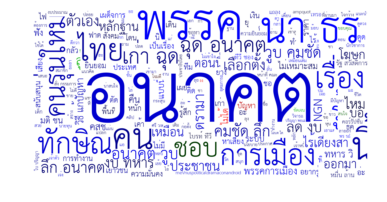

In [74]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(อนาคตใหม่_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('อนาคตใหม่.jpg')

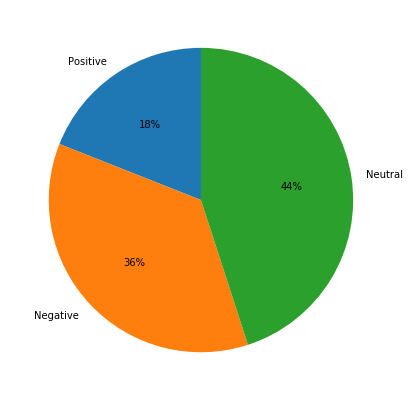

In [75]:
อนาคตใหม่_result = countNegOrPos(อนาคตใหม่_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(อนาคตใหม่_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [76]:
ธนาธร = getmoreresult('ธนาธร')
ธนาธร_onlystatus = getonlystatus(ธนาธร)
ธนาธร_afterclean = cleandata(ธนาธร_onlystatus)
ธนาธร_afterDelStopWord = delStopWord(ธนาธร_afterclean)

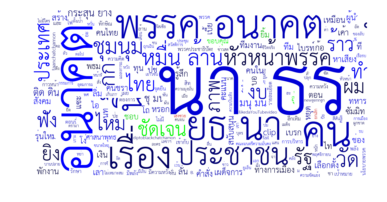

In [77]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(ธนาธร_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('ธนาธร.jpg')

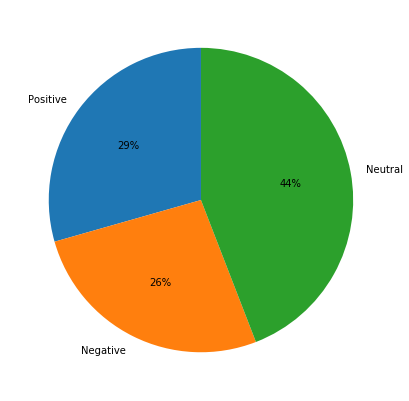

In [78]:
ธนาธร_result = countNegOrPos(ธนาธร_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(ธนาธร_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [79]:
label = "Thanatorn"
results_count_pos_personal.append(ธนาธร_result[0])
results_label_pos_personal.append(label)
results_count_neg_personal.append(ธนาธร_result[1])
results_label_neg_personal.append(label)
results_count_neu_personal.append(ธนาธร_result[2])
results_label_neu_personal.append(label)

In [80]:
อนาคตใหม่_count = len(อนาคตใหม่_onlystatus)+len(ธนาธร_onlystatus)
results_count.append(อนาคตใหม่_count)
results_label.append('Anakodmai')

In [81]:
label = "Anakodmai"
results_count_pos_party.append(อนาคตใหม่_result[0])
results_label_pos_party.append(label)
results_count_neg_party.append(อนาคตใหม่_result[1])
results_label_neg_party.append(label)
results_count_neu_party.append(อนาคตใหม่_result[2])
results_label_neu_party.append(label)

# พรรคเกียน : สมบัติ บุญงามอนงค์

In [82]:
เกียน = getmoreresult('เกียน')
เกียน_onlystatus = getonlystatus(เกียน)
เกียน_afterclean = cleandata(เกียน_onlystatus)
เกียน_afterDelStopWord = delStopWord(เกียน_afterclean)

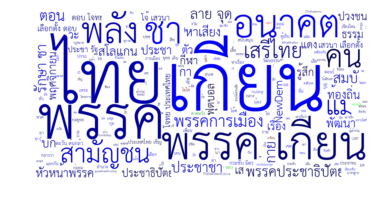

In [83]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(เกียน_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('เกียน.jpg')

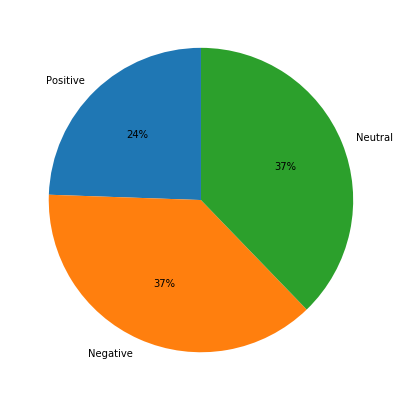

In [84]:
เกียน_result = countNegOrPos(เกียน_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(เกียน_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [85]:
สมบัติ_บุญงามอนงค์ = getmoreresult('สมบัติ บุญงามอนงค์')
สมบัติ_บุญงามอนงค์_onlystatus = getonlystatus(สมบัติ_บุญงามอนงค์)
สมบัติ_บุญงามอนงค์_afterclean = cleandata(สมบัติ_บุญงามอนงค์_onlystatus)
สมบัติ_บุญงามอนงค์_afterDelStopWord = delStopWord(สมบัติ_บุญงามอนงค์_afterclean)

In [86]:
len(สมบัติ_บุญงามอนงค์_onlystatus)

0

In [87]:
label = "Sombaht"
results_count_pos_personal.append(0)
results_label_pos_personal.append(label)
results_count_neg_personal.append(0)
results_label_neg_personal.append(label)
results_count_neu_personal.append(0)
results_label_neu_personal.append(label)

In [88]:
เกียน_count = len(เกียน_onlystatus)+len(สมบัติ_บุญงามอนงค์_onlystatus)
results_count.append(เกียน_count)
results_label.append('Kian')

In [89]:
label = "Kian"
results_count_pos_party.append(เกียน_result[0])
results_label_pos_party.append(label)
results_count_neg_party.append(เกียน_result[1])
results_label_neg_party.append(label)
results_count_neu_party.append(เกียน_result[2])
results_label_neu_party.append(label)

# พรรครวมพลังประชาชาติไทย : จัตุมงคล และ สุเทพ

In [90]:
รวมพลังประชาชาติไทย = getmoreresult('รวมพลังประชาชาติไทย')
รวมพลังประชาชาติไทย_onlystatus = getonlystatus(รวมพลังประชาชาติไทย)
รวมพลังประชาชาติไทย_afterclean = cleandata(รวมพลังประชาชาติไทย_onlystatus)
รวมพลังประชาชาติไทย_afterDelStopWord = delStopWord(รวมพลังประชาชาติไทย_afterclean)

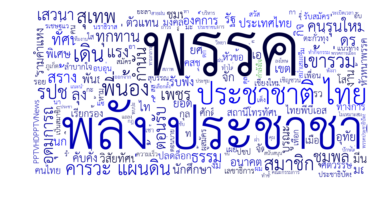

In [91]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(รวมพลังประชาชาติไทย_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('รวมพลังประชาชาติไทย.jpg')

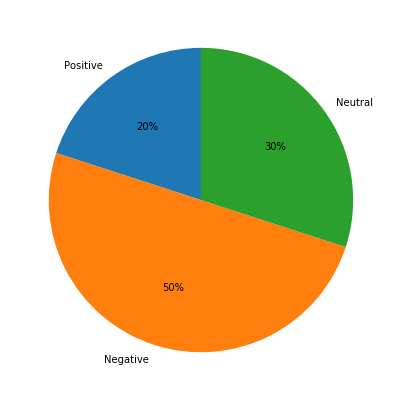

In [92]:
รวมพลังประชาชาติไทย_result = countNegOrPos(รวมพลังประชาชาติไทย_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(รวมพลังประชาชาติไทย_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [93]:
สุเทพ = getmoreresult('สุเทพ')
สุเทพ_onlystatus = getonlystatus(สุเทพ)
สุเทพ_afterclean = cleandata(สุเทพ_onlystatus)
สุเทพ_afterDelStopWord = delStopWord(สุเทพ_afterclean)

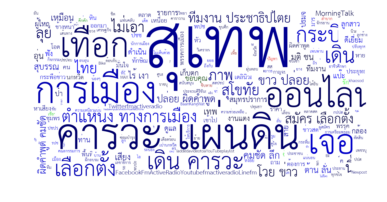

In [94]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(สุเทพ_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('สุเทพ.jpg')

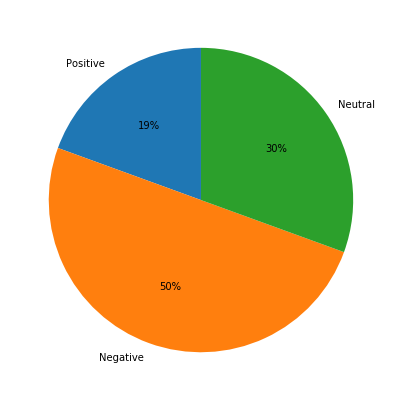

In [95]:
สุเทพ_result = countNegOrPos(สุเทพ_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(สุเทพ_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [96]:
label = "Suthep"
results_count_pos_personal.append(สุเทพ_result[0])
results_label_pos_personal.append(label)
results_count_neg_personal.append(สุเทพ_result[1])
results_label_neg_personal.append(label)
results_count_neu_personal.append(สุเทพ_result[2])
results_label_neu_personal.append(label)

In [97]:
จัตุมงคล = getmoreresult('จัตุมงคล')
จัตุมงคล_onlystatus = getonlystatus(จัตุมงคล)
จัตุมงคล_afterclean = cleandata(จัตุมงคล_onlystatus)
จัตุมงคล_afterDelStopWord = delStopWord(จัตุมงคล_afterclean)

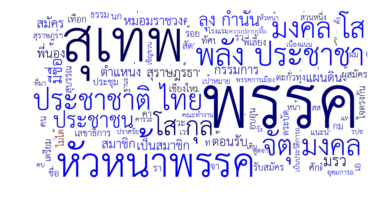

In [98]:
wordcloud = WordCloud(width=1600, height=800,font_path='THSarabunNew.ttf',
                      stopwords = ' '.join(stopwords.words('thai')),
                      background_color="white",
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(' '.join(word_tokenize(''.join(จัตุมงคล_afterDelStopWord))))

color_to_words = {
    'red': neg,
    'green': pos
}
default_color = 'blue'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('จัตุมงคล.jpg')

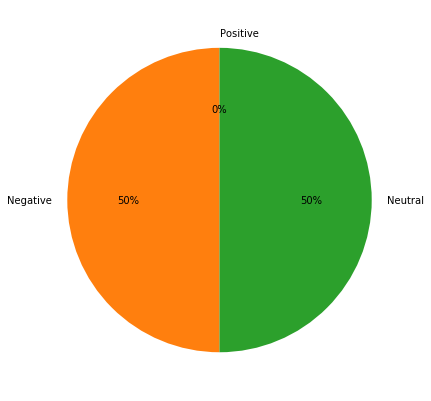

In [99]:
จัตุมงคล_result = countNegOrPos(จัตุมงคล_afterDelStopWord)
plt.figure(figsize=[7,7])
plt.pie(จัตุมงคล_result,autopct='%d%%',startangle=90,labels=result_countPosNeg_labels)
plt.show()

In [100]:
label = "Jatumongkol"
results_count_pos_personal.append(จัตุมงคล_result[0])
results_label_pos_personal.append(label)
results_count_neg_personal.append(จัตุมงคล_result[1])
results_label_neg_personal.append(label)
results_count_neu_personal.append(จัตุมงคล_result[2])
results_label_neu_personal.append(label)

In [101]:
รวมพลังประชาชาติไทย_count = len(รวมพลังประชาชาติไทย_onlystatus)+len(สุเทพ_onlystatus)+len(จัตุมงคล_onlystatus)
results_count.append(รวมพลังประชาชาติไทย_count)
results_label.append('Ruampalangpachathai')

In [102]:
label = "Ruampalangpachathai"
results_count_pos_party.append(รวมพลังประชาชาติไทย_result[0])
results_label_pos_party.append(label)
results_count_neg_party.append(รวมพลังประชาชาติไทย_result[1])
results_label_neg_party.append(label)
results_count_neu_party.append(รวมพลังประชาชาติไทย_result[2])
results_label_neu_party.append(label)

# วิเคราะห์ข้อมูลที่ได้มา

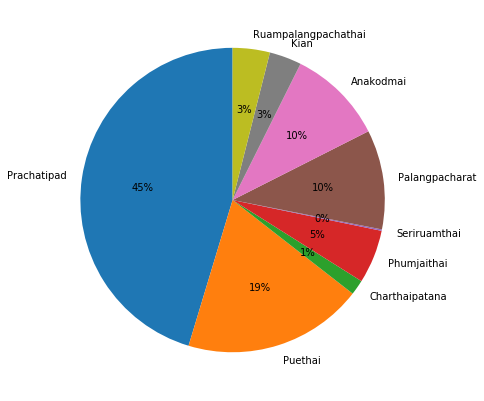

In [138]:
plt.figure(figsize=[7,7])
plt.pie(results_count,autopct='%d%%',startangle=90,labels=results_label)
plt.savefig('SocialComparepie.jpg')
plt.show()


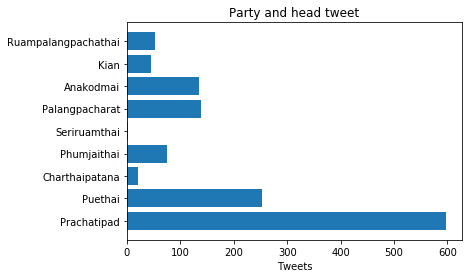

In [137]:
plt.barh(results_label, results_count, align='center', alpha=1)
plt.yticks(results_label, results_label,)
plt.xlabel('Tweets')
plt.title('Party and head tweet')
plt.savefig('SocialComparebar.jpg')
 
plt.show()

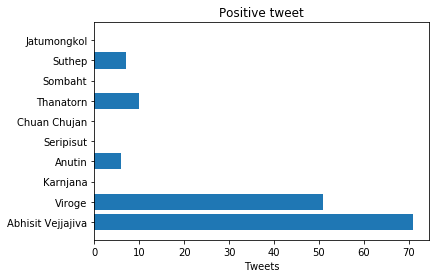

In [136]:
plt.barh(results_label_pos_personal, results_count_pos_personal, align='center', alpha=1)
plt.yticks(results_label_pos_personal, results_label_pos_personal,)
plt.xlabel('Tweets')
plt.title('Positive tweet')
 
plt.savefig('SocialPositive.jpg')
plt.show()

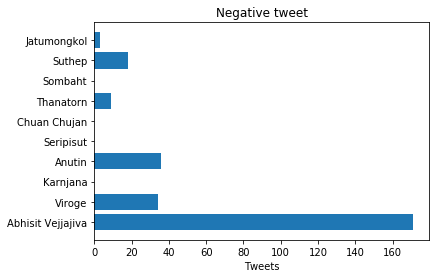

In [135]:
plt.barh(results_label_neg_personal, results_count_neg_personal, align='center', alpha=1)
plt.yticks(results_label_neg_personal, results_label_neg_personal,)
plt.xlabel('Tweets')
plt.title('Negative tweet')
 
plt.savefig('SocialNegative.jpg')
plt.show()

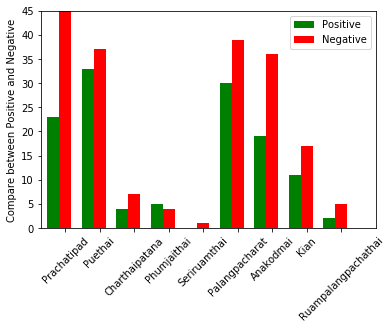

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111)

## the data
N = len(results_count_pos_party)
menMeans = [18, 35, 30, 35, 27]
womenMeans = [25, 32, 34, 20, 25]

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, results_count_pos_party, width,color='green')

rects2 = ax.bar(ind+width, results_count_neg_party, width,color='red')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,45)
ax.set_ylabel('Compare between Positive and Negative')
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(results_label_pos_party)
plt.setp(xtickNames, rotation=45, fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('Positive', 'Negative') )

plt.savefig('CompareNegPos.jpg')
plt.show()